## A Demonstration of the Doppler Effect 

The acoustic Doppler effect [1] is the apparent change in the frequency of a wave when a sound source moves relative to the observer.
With this Jupyter Notebook, we will record the Doppler effect while moving a sound source emitting the source signal $s(t)$. The recorded signal will be denoted by $p(t)$. After recording, we will have a look at the spectrogram of $p(t)$. The instantaneous frequency of $p(t)$ relates to the speed $v(t)$ of the moving sound source. We will therefore track the instantaneous frequency and usie it to estimate $v(t)$.

Your mobile device (your phone, tablet, a device you can easily move back and forth...) will serve as a sound source. The source signal $s(t)$ will be a 2kHz sinusoid. You can download a corresponding .wav file to your mobile device from https://github.com/tdietzen/DopplerDemo/blob/main/2k_-6dbFS.wav.

To track the instantaneous frequency, we use the Kalman Adaptive Notch Filter (KalmANF) algorithm [2]. 

Contact for questions and feedback: Thomas Dietzen (thomas.dietzen@esat.kuleuven.be)


### Package import

Firstly let us import the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [1]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from  matplotlib import patches
from matplotlib.ticker import FormatStrFormatter
import IPython
from IPython.display import Audio, Image
%matplotlib notebook
%matplotlib inline
from IPython.display import display, HTML

### Recording the Moving Sound Source

In this section we will do the following:

1. Record the signal $p(t)$
2. Compute the spectrogram of $p(t)$
3. Plot the spectrogram of $s(t)$

To record audio data, we use the [sounddevice (sd) package](https://python-sounddevice.readthedocs.io/en/0.4.6/) in Python to gain access to the microphone on your computer or external sound card. We just need to set the sampling frequency and duration of the sound we would like to record. To choose a specific input/output audio device, you can run the command sd.query_devices() to see which devices are available on your machine and then use sd.default.device to choose a specific input/output.

In [ ]:
# check which audio devices are available
sd.query_devices()

In [3]:
# set the audio devices from the query list [input, output]
sd.default.device = [2, 0]

If you have downloaded the 2kHz sinusoid .wav file to your mobile device, we are now ready for the recording. To record 10s of the Doppler effect, do the following:

1. Play back the sinosoid $s(t)$ from your phone
2. Right after, start recording $p(t)$ by running the cell below
3. Quickly move your phone back and forth to the microphone to reproduce the Doppler effect

Recording audio ...
finished recording.
Recorded Signal:


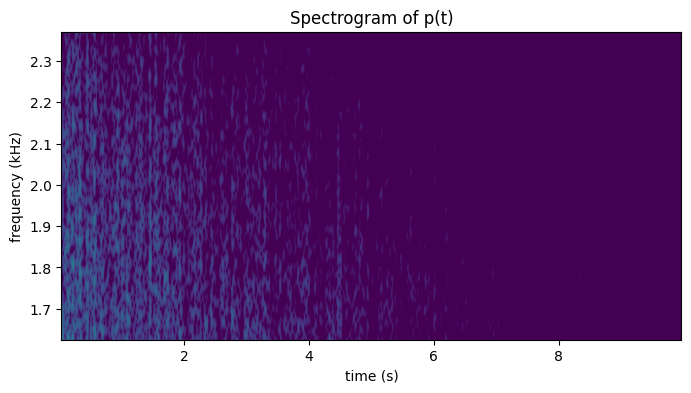

In [6]:
### RECORDING PARAMETERS ###

 # recording time (s)
T = 10  
# sampling freq (Hz)
fs = 8000 


### STFT PARAMETERS ###

# window length
nperseg = 512
# number of points for the FFT 
nfft = 4*nperseg   
# window overlap
noverlap = 7*nperseg/8  


### START RECORDING ###

# set number of samples to a multiple of the window shift
nshift = nperseg-noverlap
L = int(round(T*fs/(nshift))*(nshift))

print ('Recording audio ...')
p = sd.rec(L, blocking=True,samplerate=fs, channels=1)
print ('finished recording.')

# Play back recorded signal
print("Recorded Signal:")
IPython.display.display(Audio(p.T, rate=fs,normalize=True))


### COMPUTE THE SPECTROGRAM ###

# window length
nperseg = 512
# number of points for the FFT 
nfft = 4*nperseg   
# window overlap
noverlap = 7*nperseg/8  

# compute the spectrogram
f_sg, t_sg, Z_mag = signal.spectrogram(p[:,0], fs=fs,nperseg=nperseg,nfft=nfft,window='cosine',mode='magnitude',noverlap=noverlap)
# convert the magnitude to dB
Z_dB = 10*np.log10(Z_mag**2) 


### PLOTTING ###

# color limits
min_dB = -100
max_dB = -40

# frequency limits
min_freqBin = int(13*nfft/64)
max_freqBin = int(19*nfft/64-1)

# time limits
t_firstframe = nperseg/(2*fs)
t_lastframe = T-nperseg/(2*fs)

# plot spectrogram
extent = t_firstframe, t_lastframe, f_sg[min_freqBin]/1000, f_sg[max_freqBin]/1000  # defines the corners of the "image"
fig, axes = plt.subplots(figsize=(8, 4)) 
sp = axes.imshow(Z_dB[min_freqBin:max_freqBin,:], origin='lower',aspect='auto',extent=extent, vmin=min_dB, vmax=max_dB)
axes.set_xlabel('time (s)')
axes.set_ylabel('frequency (kHz)')
axes.set_xlim(t_firstframe, t_lastframe)
axes.set_ylim(f_sg[min_freqBin]/1000, f_sg[max_freqBin]/1000)
axes.set_title('Spectrogram of p(t)');

### Source Speed Estimation

The instanteous frequency of $p(t)$ is (approximately) given by $f(t) = \dfrac{c}{(c-v(t))}f_0$, where $f_0$ is the frequency of $s(t)$ and $c$ is the speed of sound [1]. From an estimate $\hat{f}$ of $f$, we can therefore obtain an estimate $\hat{v}$ by 

\begin{align}
\hat{v}(t) = c\frac{\hat{f}(t)-f_0}{\hat{f}(t)}
\end{align}

So let's do the following:

1. Track the frequency of $p(t)$ with the KalmANF algorithm [2], yielding the estimate $\hat{f}(t)$
2. Compute the source speed estimate $\hat{v}(t)$ from $\hat{f}(t)$, assuming that we know the frequency $f_0$ of the source signal $s(t)$
3. Plot a spectrogram of $p(t)$ and overlay the tracked frequency $\hat{f}(t)$
5. Plot the estimated source speed $\hat{v}(t)$

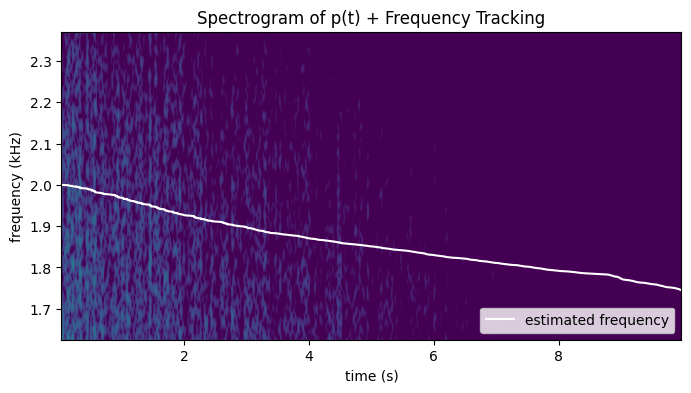

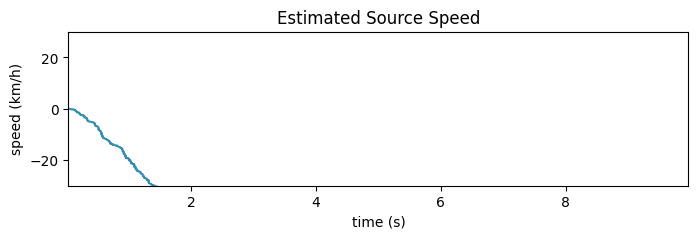

In [8]:
### DEFINITION OF THE FREQUENCY TRACKING ALGORITHM ###

def kalmanf (y, fs, rho, q, r):
    
    '''
    Kalman-Based Adaptive Notch Filter (KalmANF)
    

    Input arguments:
        y       - input data vector (Lx1)
        fs      - sampling frequency (Hz)
        rho     - pole raduis (value between 0 and 1, with values closer to 1 creating a narrower notch)
        q       - Covariance of process noise
        r       - Covariance of measurement noise
        
    Returns:
        f_kal   - Estimated frequency over time (Lx1)
        a_kal   - Estimated filter coefficient over time (Lx1)
        e_kal   - Output from notch filter (Lx1)
        
    '''  


    s_kal = np.zeros(len(y)) # intermediate variable of ANF
    e_kal = np.zeros(len(y)) # output of ANF
    a_kal = np.zeros(len(y)) # coefficient to be updated
    f_kal = np.zeros(len(y)) # frequency to be tracked
    
    p_cov = 0 # initialise covariance of the error
    K = np.zeros(len(y)) # Kalman gain
        
    for n in np.arange(2,len(y),1): # start loop from two samples ahead because we need samples at m-1 and m-2 
        
        # Prediction
        # a(n|n-1) is simply a(n-1) since the state transition matrix is an identiy
        p_cov = p_cov + q; # update covariance of prediction error
        
        
        # Estimation
        s_kal[n] = y[n] + rho*s_kal[n-1]*a_kal[n-1] - (rho**2)*s_kal[n-2] # Define s_kal from data
        K[n] = (s_kal[n-1])/( (s_kal[n-1]**2) + r/p_cov )
        e_kal[n] = s_kal[n] - s_kal[n-1]*a_kal[n-1] + s_kal[n-2] 
        a_kal[n] = a_kal[n-1] + K[n]*e_kal[n]
    
        # Update covariance of error
        p_cov = (1 - K[n]*s_kal[n-1])*p_cov
        
        # Compute frequency
        if (a_kal[n] > 2) or (a_kal[n] < -2):
            a_kal[n] = 0 # reset coefficient if a is out of range to compute acos
        
        omega_hat_kal = np.arccos(a_kal[n]/2)
        f_kal[n] = (omega_hat_kal*fs)/(2*np.pi) # estimated frequency
    
    return f_kal, a_kal, e_kal


### FREQUENY TRACKING ####

# Parameters of the KalmANF algorithm
# Pole radius
rho = 0.98
# variance of process noise
q= 1e-4
# variance of observation noise 
r= 1

# Apply the KalmANF algorithm for frequency tracking
f_kal, a_kal, e_kal = kalmanf (p, fs, rho, q=q, r=r) 


### SPEED ESTIMATION ####

# speed of sound
c = 343;
# frequency of source signal
f0 = 2000;

# estimated source speed (m/s)
v_estim_mps = c*(f_kal-f0)/(f_kal+1e-6);
# estimated source speed (km/h)
v_estim_kmph = 3.6*v_estim_mps;


### PLOTTING ###

# Total duration of signal (number of samples)
L = len(p)    
# range of samples
n = np.arange(0,L,1) 
# time range of signal
tt = n/fs  

# plot spectrogram
fig, axes = plt.subplots(figsize=(8, 4)) 
sp = axes.imshow(Z_dB[min_freqBin:max_freqBin,:], origin='lower',aspect='auto',extent=extent, vmin=min_dB, vmax=max_dB)

# plot estimated frequency
axes.plot(tt,f_kal/1000,'-',color='white',markersize=0.1,label='estimated frequency')
axes.set_xlabel('time (s)')
axes.set_ylabel('frequency (kHz)')
axes.set_xlim(t_firstframe, t_lastframe)
axes.set_ylim(f_sg[min_freqBin]/1000, f_sg[max_freqBin]/1000)
axes.legend(loc='lower right')
axes.set_title('Spectrogram of p(t) + Frequency Tracking')

# plot estimated source speed
fig, axes = plt.subplots(figsize=(8, 2)) 
axes.plot(tt,v_estim_kmph,'-',color=(0.2078, 0.5569, 0.6941),markersize=0.1,label='tracked frequency')
axes.set_xlabel('time (s)')
axes.set_ylabel('speed (km/h)');
axes.set_xlim(t_firstframe, t_lastframe)
axes.set_ylim(-30, 30);
axes.set_title('Estimated Source Speed');



### Conclusion

That's it! If things worked well, you should now see a figure showing the estimated speed of your mobile device during recording. An untrained human can move their arms with speeds up to 30 km/h, so you can try how fast you can go.


## References

[1] P. M. Morse and K. U. Ingard, *Theoretical Acoustics*. Princeton University Press, 1986.

[2] R. Ali, T. van Waterschoot, "[A frequency tracker based on a Kalman filter update of a single parameter adaptive notch filter](https://ftp.esat.kuleuven.be/pub/SISTA/rali/Reports/23-57.pdf)," in *Proc. of the 26th International Conference on Digital Audio Effects (DAFx23)*, Copenhagen, Denmark, September 2023.


## Acknowledgements

This Jupyter Notebook is largely inspired by the adaptive notch filter demo of Randall Ali's '[Acoustic Signal Processing Demos with Jupyter Notebooks](https://github.com/randyaliased/acs-sp-demos)', a growing collection designed to demonstrate several concepts in signal processing primarily with acoustic signals.